In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.image as im

import numpy as np
import glob
import os
import sys
import cv2
import glob

from scipy import io

### Load Dataset (AFW)

(450, 450, 3)


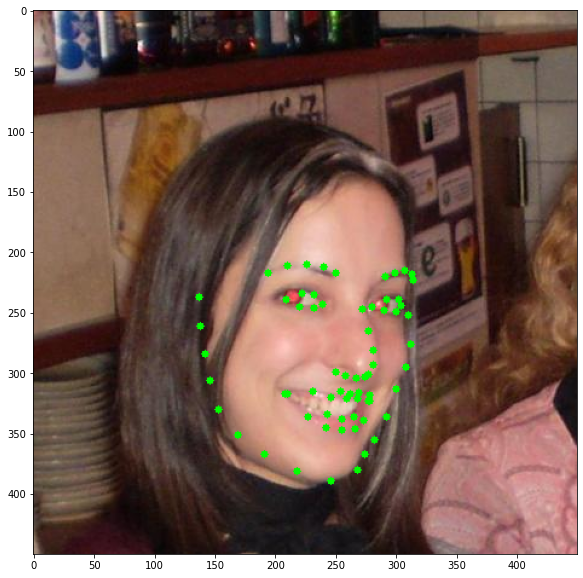

(450, 450, 3)


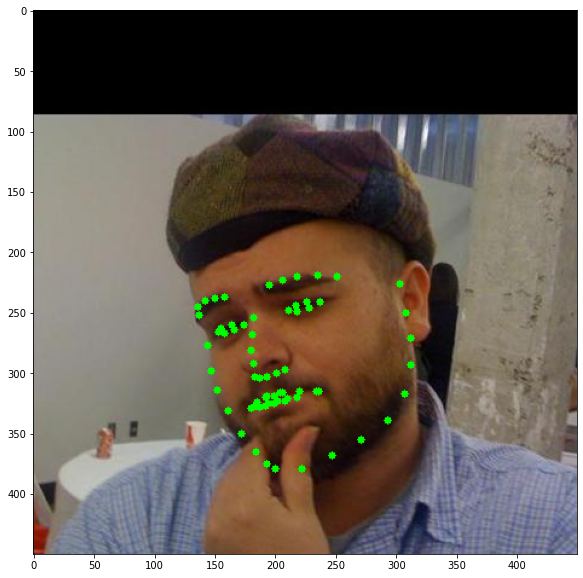

(450, 450, 3)


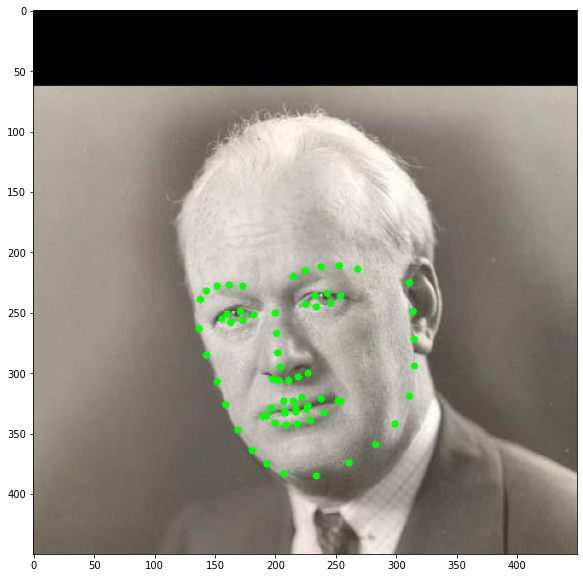

In [2]:

data_dir = 'data/AFW/'
landmark_dir = 'data/AFW_landmark/'

file_list = glob.glob(data_dir+'*_0.jpg')
file_list = map(os.path.basename, file_list)
name_list = list(set(map(lambda x : x[:-4], file_list)))

def _read_mat(file_path):
    matfile = io.loadmat(file_path)
    label = (matfile['pts_2d']).astype(np.float32)
    return label

for name in name_list[:3]:
    image = im.imread(os.path.join(data_dir, name+'.jpg'))
    print(image.shape)

    label = _read_mat(landmark_dir+name+'_pts.mat')
    for x, y in label:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 0), -1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.show()

### Parameter / Model Load

In [ ]:
INPUT_SIZE = 368#200
MAP_SIZE = 100
MAP_SIGMA = 2.5

LANDMARK_NUM = list(range(68))#[4,9,16,36] # 원하는 point 를 입력
LANDMARK_SIZE = len(LANDMARK_NUM) # ear : 55 / face : 68
LEARNING_RATE = 0.0001
BATCH_SIZE = 10
EPOCH = 100

split_rate = 0.9

model = tf.keras.models.load_model('saved_model/saved_model_openpose_face2ear_v1.h5', compile=False)

### Data pipeline setting

In [4]:
input_size_h = INPUT_SIZE/2
feat_size = model.get_layer('feature_map').output_shape[1]

#--------------------------------------

test_dataset = tf.data.Dataset.from_tensor_slices(name_list)

def process_path(name):
    image_path = data_dir+name+'.jpg'
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.cond(tf.shape(image)[-1] != 3,
                    lambda: tf.image.grayscale_to_rgb(image),
                    lambda: tf.identity(image))
    image_shape = tf.shape(image)
    
    label = tf.numpy_function(_read_mat, [landmark_dir+name+'_pts.mat', image_shape], tf.float32)
    label = tf.numpy_function(_make_confidence_map, [label, MAP_SIGMA], tf.float32)
    
    image.set_shape([None, None, None])
    image = tf.image.resize(image, [INPUT_SIZE, INPUT_SIZE])
    label.set_shape([MAP_SIZE, MAP_SIZE, LANDMARK_SIZE])
    
    return image, label

def _read_mat(file_path, input_shape):
    matfile = io.loadmat(file_path)
    norm = [input_shape[1]/2, input_shape[0]/2]
    label = ((matfile['pts_2d']-norm)/norm).astype(np.float32)
    return label

def _read_txt(file_path, input_shape):
    with open(file_path, 'r') as f:
        lines_list = f.readlines()
        temp = list(map(lambda l : list(map(float, l.split(' '))), lines_list[3:-1]))
        temp = np.array(temp)
    norm = [input_shape[1]/2, input_shape[0]/2]
    label = ((temp-norm)/norm).astype(np.float32)
    return label[LANDMARK_NUM]

def _make_confidence_map(label, sigma = 2.5):
    
    norm = [MAP_SIZE/2, MAP_SIZE/2]
    new_label = label*norm+norm
    
    grid_x = np.tile(np.arange(MAP_SIZE), (MAP_SIZE, 1))
    grid_y = np.tile(np.arange(MAP_SIZE), (MAP_SIZE, 1)).transpose()
    grid_x = np.tile(np.expand_dims(grid_x, axis=-1),LANDMARK_SIZE)
    grid_y = np.tile(np.expand_dims(grid_y, axis=-1),LANDMARK_SIZE)
    
    grid_distance = (grid_x - new_label[:,0]) ** 2 + (grid_y - new_label[:,1]) ** 2
    confidence_map = np.exp(-1 * grid_distance / sigma ** 2) # why 0.5?
    
    return confidence_map.astype(np.float32)

def _crop_image_one(img, label): # with label norm
    pad = 1
    
    img_h, img_w, img_c = img.shape
    
    idx = np.array([img_w/2, img_h/2])
    
    label = label*idx+idx
    
    label_x_info = np.array([min(label[:,0]), max(label[:,0])])
    label_y_info = np.array([min(label[:,1]), max(label[:,1])])
    
    ear_w = label_x_info[1]-label_x_info[0]
    ear_h = label_y_info[1]-label_y_info[0]

    s_x = max(int(label_x_info[0]-ear_w*10), 0)
    e_x = min(int(label_x_info[0]+ear_w*10), img_w)
    s_y = max(int(label_y_info[0]-ear_h*10), 0)
    e_y = min(int(label_y_info[0]+ear_h*10), img_h)

    c_img = img[s_y:e_y, s_x:e_x, :]
    c_label = label - np.array([s_x, s_y])
    
    new_img_h, new_img_w, _ = c_img.shape
    
    norm = [new_img_w/2, new_img_h/2]
    c_label = ((c_label-norm)/norm).astype(np.float32)
    return c_img, c_label

def _shrink_image_one(img, label):
    img_h, img_w, img_c = img.shape
    idx = np.array([img_w/2, img_h/2])
    label = label*idx+idx
    
    max_ratio = 4
    sh_ratio = np.random.randint(1,max_ratio)
    
    min_x = int(np.min(label[:,0]))
    max_x = int(np.max(label[:,0]))

    image_left = img[:,0:min_x,:]
    image_right = img[:,max_x:-1,:]
    image_mid = img[:,min_x:max_x:sh_ratio,:]

    sh_img = np.concatenate((image_left, image_mid, image_right), axis = 1)
    sh_label = (label-np.array([min_x,0]))/np.array([sh_ratio,1])+np.array([min_x,0])
    
    new_img_h, new_img_w, _ = sh_img.shape
    norm = [new_img_w/2, new_img_h/2]
    sh_label = ((sh_label-norm)/norm).astype(np.float32)
    
    return sh_img, sh_label
    
def _flip_image_one(img, label):
    c = np.random.randint(2)
    f_img, f_label = tf.cond(c==1,
                             lambda: (tf.image.flip_left_right(img), label * np.array([-1, 1])),
                             lambda: (img, label))
    return f_img, f_label

def _shift_image_one(img, label, padding = b'zero'):
    img_h, img_w, img_c = img.shape
    label_p, _ = label.shape
    
    if padding == b'ori': s_img = img[:]
    elif padding == b'zero': s_img = np.zeros_like(img, dtype=np.float32)
    s_label = np.expand_dims(label, axis=0)
    
    label_x_info = np.array([min(label[:,0]), max(label[:,0])])* img_w/2 + img_w/2
    label_y_info = np.array([min(label[:,1]), max(label[:,1])])* img_h/2 + img_h/2
    
    label_x_info = label_x_info.astype(np.int)
    label_y_info = label_y_info.astype(np.int)
    
    shift_x = np.random.randint(-label_x_info[0], img_w - label_x_info[1])
    shift_y = np.random.randint(-label_y_info[0], img_h - label_y_info[1])
    
    shift_x = min(shift_x, img_w//6)
    shift_y = min(shift_y, img_h//6)
    
    if shift_x < 0:
        get_x = (-shift_x, img_w)
        put_x = (0, img_w + shift_x)
    else:
        get_x = (0, img_w - shift_x)
        put_x = (shift_x, img_w)
    if shift_y < 0:
        get_y = (-shift_y, img_h)
        put_y = (0, img_h + shift_y)
    else:
        get_y = (0, img_h - shift_y)
        put_y = (shift_y, img_h)

    if padding == b'edge': s_img = np.pad(img[get_y[0]:get_y[1], get_x[0]:get_x[1], :], ((img_h-get_y[1],get_y[0]),(img_w-get_x[1],get_x[0]),(0,0)), mode='edge')
    else: s_img[put_y[0]:put_y[1], put_x[0]:put_x[1], :] = img[get_y[0]:get_y[1], get_x[0]:get_x[1], :]
    s_label = np.append(np.expand_dims(label[:,0] + (shift_x)/(img_w/2), axis = -1),
                          np.expand_dims(label[:,1] + (shift_y)/(img_h/2), axis = -1), axis = 1)
    
    return s_img, s_label

def _downsize_image(img, label):
    img_h, img_w, img_c = img.shape

    size = 1 + np.random.randint(101)/100 # 1~2 (100 step)
    resized_image = cv2.resize(img ,(int(img_w/size), int(img_h/size)))

    new_img_h, new_img_w, _ = resized_image.shape

    str = np.array([int(img_w/2 * (1 - 1/size)), int(img_h/2 * (1 - 1/size))])
    dst = str + np.array([new_img_w, new_img_h])

    idx = np.array([new_img_w/2, new_img_h/2])
    new_label = (label*idx)+idx + str

    pad_image = np.zeros_like(img, dtype=np.float32)
    pad_image[str[1]:dst[1],str[0]:dst[0],:] = resized_image

    norm = [img_w/2, img_h/2]
    new_label = ((new_label-norm)/norm).astype(np.float32)

    return pad_image, new_label

AUTOTUNE = tf.data.experimental.AUTOTUNE


test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)

def apply_blur(img, landmark):
    blur = _gaussian_kernel(5, 2.5, landmark, img.dtype)
    img = tf.nn.depthwise_conv2d(img, blur, [1,1,1,1], 'SAME')
    return img

2022-08-19 20:00:48.946185: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-08-19 20:00:51.129807: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


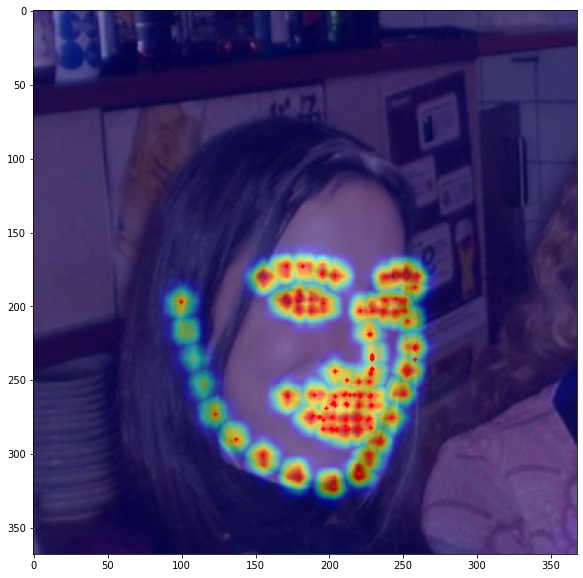

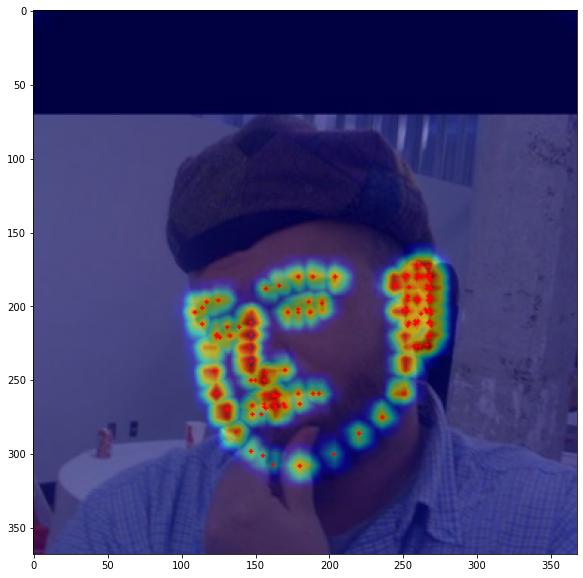

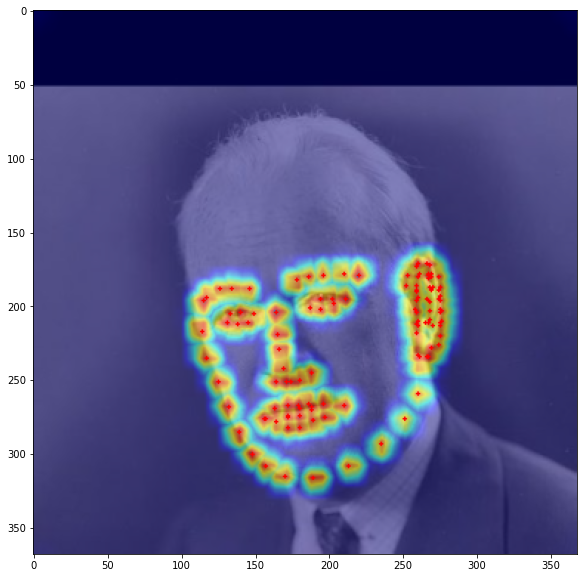

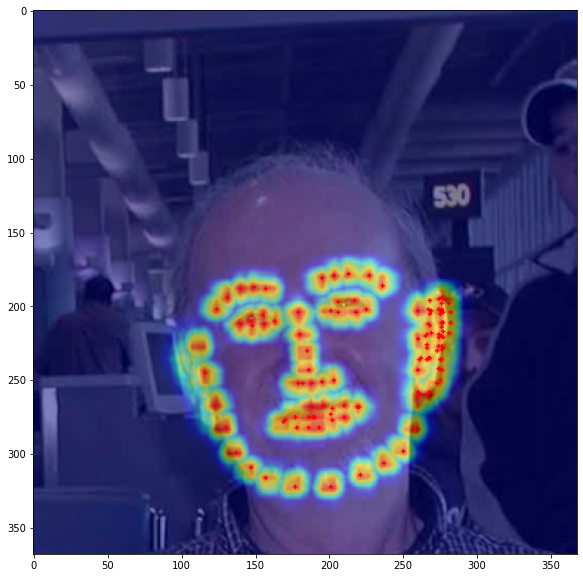

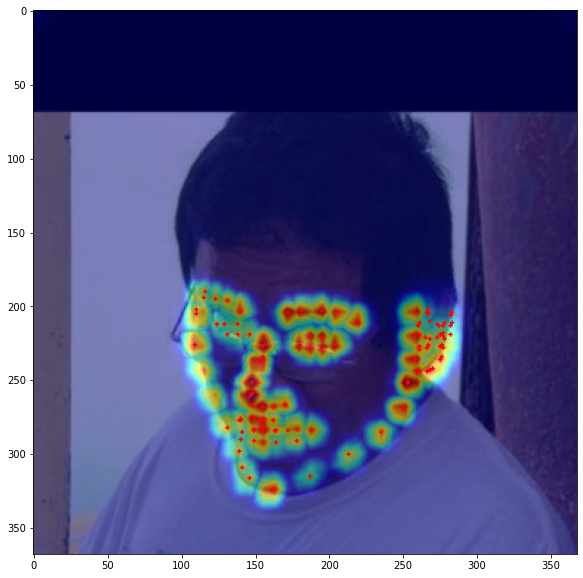

In [6]:
pred = tf.keras.backend.function([model.input], [model.get_layer('s6_e').output, model.get_layer('s6').output])
for image_raw, ture_label in test_dataset.take(1):
    images = image_raw.numpy()
    result_all = pred([images])
    labels = np.append(result_all[0], result_all[1], axis=-1)
    for i in range(5):
        heatmap = tf.image.resize(labels[i], (INPUT_SIZE, INPUT_SIZE))

        temp = apply_blur(tf.expand_dims(heatmap, axis=0), 123)
        temp = np.argmax(np.reshape(temp, (-1, 123)), axis=0)

        heatmap = cv2.applyColorMap(np.uint8(np.tile(np.amax(heatmap, axis=-1, keepdims=True), 3)*255), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        image_o = images[i]*0.5 + heatmap/255*0.5
        
        for num, idx in enumerate(temp):
            x, y = idx%INPUT_SIZE, idx//INPUT_SIZE
            
            image_ear = cv2.circle(images, (round(x), round(y)), 1, (1, 0, 0), -1)
            image_o = cv2.circle(image_o, (round(x), round(y)), 1, (1, 0, 0), -1)

        plt.figure(figsize=(10, 10))
        plt.imshow(image_o)
        plt.show()